# Neater : Calculating the Big Mac Index

The [Big Mac Index](https://www.economist.com/news/2018/01/17/the-big-mac-index) is a lighthearted way to measure whether or not currencies are at their correct level.

The original notebook (written in R) is available here: https://github.com/TheEconomist/big-mac-data/blob/master/Big%20Mac%20data%20generator.ipynb

## Exercise in four parts

As the course progresses you will see different methods for writing elegant Python. To clean this notebook up and make it presentable you will need to perform the following tasks:

1. Add in documentation as to what operations are being performed. You can look at the original notebook for this.
2. Use the rules of PEP8 to modify variable names and clean up code so that it has appropriate formatting. The `autopep8` extension for Jupyter may help here.
3. Discard uneccsary working code.
4. Write a context manager to show the entirety of a pandas dataframe. Then use stacking and unstacking to format the currency values for the maximum date for all countries and display with the column index as the date and the row index as the sum.
5. For the Netherlands create a line chart showing the parity of the Euro in the Netherlands compared to the average value of the Euro across the EU
6. Use `traitles` to create a new class that gives access to the underlying comparative price for a Big Mac compared to any of the base currencies. The observer pattern should be used to determine whether the year attribute is changed, and on change it should reset the different currency values based on the appropriate year.

![Big Mac](Big-Mac.png)

## Data extraction

We only calculate the Big Mac index for certain countries, specifically these ones:

In [1]:
countries = [
    'ARG', 'AUS', 'BRA', 'GBR', 'CAN', 'CHL', 'CHN', 'CZE', 'DNK',
    'EGY', 'HKG', 'HUN', 'IDN', 'ISR', 'JPN', 'MYS', 'MEX', 'NZL',
    'NOR', 'PER', 'PHL', 'POL', 'RUS', 'SAU', 'SGP', 'ZAF', 'KOR',
    'SWE', 'CHE', 'TWN', 'THA', 'TUR', 'ARE', 'USA', 'COL', 'CRI',
    'PAK', 'LKA', 'UKR', 'URY', 'IND', 'VNM', 'GTM', 'HND',  # Venezuela removed
    'NIC', 'AZE', 'BHR', 'HRV', 'JOR', 'KWT', 'LBN', 'MDA', 'OMN',
    'QAT', 'ROU', 'EUZ']

The raw data sheet is compiled every six months by the economist contains three sets of data: the local price of a Big Mac, the exchange rate of the local currency to the US dollar, and the GDP per person of the country (in US dollars). Read it in using `pandas`, making sure to parse dates and clean up null values where there is no local price.

In [2]:
import pandas as pd

In [3]:
big_mac_countries = pd.read_csv(
    '../source-data/big-mac-source-data.csv', parse_dates=['date']
).dropna(
    subset=['local_price']
).sort_values(
    ['date', 'name']
)

big_mac_countries.tail()

name iso_a3 currency_code  local_price  dollar_ex  GDP_dollar  \
1293        Ukraine    UKR           UAH        47.00     28.715         NaN   
1294  United States    USA           USD         5.28      1.000   57607.613   
1295        Uruguay    URY           UYU       140.00     28.580         NaN   
1296      Venezuela    VEN           VEF         0.00      0.000         NaN   
1297        Vietnam    VNM           VND     65000.00  22711.500         NaN   

           date  
1293 2018-01-01  
1294 2018-01-01  
1295 2018-01-01  
1296 2018-01-01  
1297 2018-01-01

In [4]:
max_date = big_mac_countries['date'].max()
max_date

Timestamp('2018-01-01 00:00:00')

## Converting to a uniform currency

Our first step to calculate the index is to convert all of the prices to a uniform currency (we use the US dollar).

In [5]:
big_mac_countries['dollar_price'] = big_mac_countries['local_price'] / big_mac_countries['dollar_ex']
big_mac_countries.tail()

name iso_a3 currency_code  local_price  dollar_ex  GDP_dollar  \
1293        Ukraine    UKR           UAH        47.00     28.715         NaN   
1294  United States    USA           USD         5.28      1.000   57607.613   
1295        Uruguay    URY           UYU       140.00     28.580         NaN   
1296      Venezuela    VEN           VEF         0.00      0.000         NaN   
1297        Vietnam    VNM           VND     65000.00  22711.500         NaN   

           date  dollar_price  
1293 2018-01-01      1.636775  
1294 2018-01-01      5.280000  
1295 2018-01-01      4.898530  
1296 2018-01-01           NaN  
1297 2018-01-01      2.861986

## Calculating the raw index

Now that we've done this, we can pick out our five 'base' currencies: the US dollar (USD), Euro (EUR), British pound (GBP), Japanese yen (JPY), and Chinese yuan (CNY).

Note for the Euro there are a number of different prices of a Big Mac across the eurozone, so we'll use the average of the Euro burger price, calculated using the `pivot_table` method on the DataFrame.

In [6]:
base_countries = ['USD', 'EUR', 'GBP', 'JPY', 'CNY']

In [7]:
big_mac_countries.set_index(['currency_code', 'date'], inplace=True)

In [8]:
filtered_currencies = big_mac_countries.loc[base_countries].pivot_table('dollar_price', 'currency_code', 'date')

Calculating the index is as simple as dividing the local price by the price in the base currency. You can do this neatly by taking advantage of broadcasting and matching on indexes in pandas. 

In [9]:
adjusted_price = big_mac_countries.reset_index().set_index(['name', 'date'])['dollar_price'] / filtered_currencies - 1

We can take a quick look at a basic plot using standard pandas plotting, showing parity of each currency with the US over time:

In [10]:
%matplotlib inline

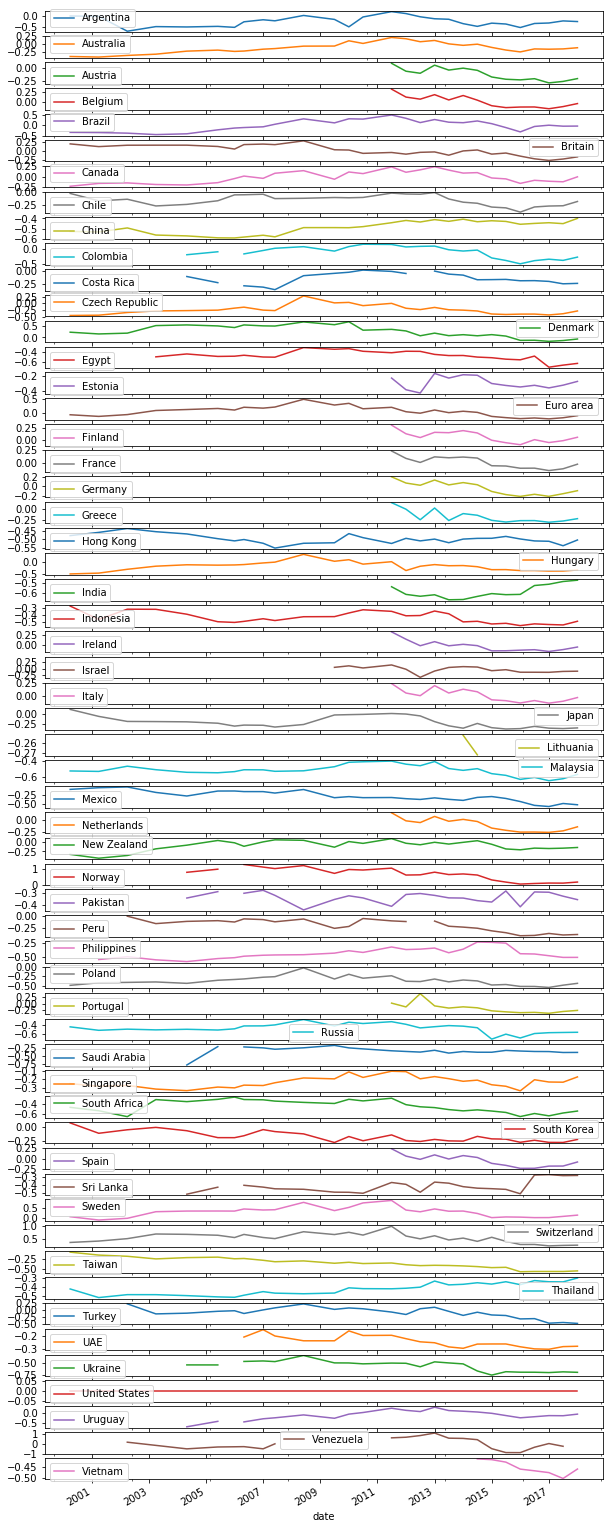

In [11]:
adjusted_price.loc['USD'].unstack(0).plot(subplots=True, figsize=(10, 30));

Or using the altair library we can get some nice plots very easily. In this case show and highlight currencies by the amount they are over or under valued.

In [12]:
import altair as alt

In [13]:
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

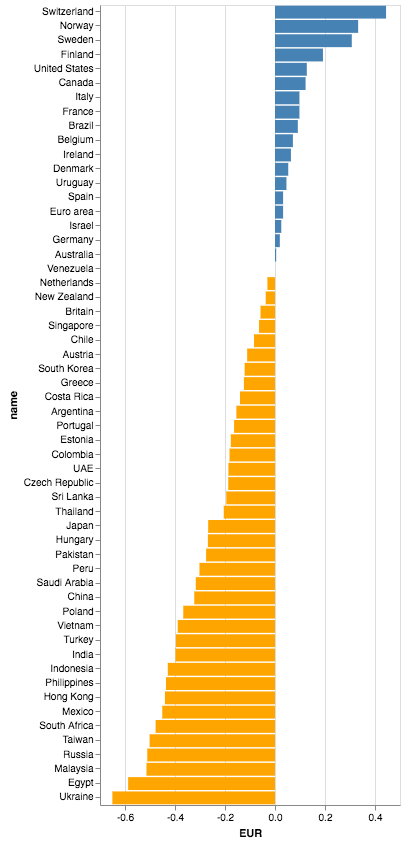

In [14]:
alt.Chart(
    adjusted_price.loc['EUR', pd.IndexSlice[:, max_date]].reset_index()
).mark_bar().encode(
    x='EUR:Q', 
    y=alt.Y(
        'name:N',
        sort=alt.SortField(
            field='EUR', 
            op='sum',
            order='descending')),
    color=alt.condition(
        alt.datum.EUR < 0, 
        alt.value('orange'), 
        alt.value('steelblue'))).properties(
    height=800,
    width=300
)

Finally you can create a simple interactive plot that makes it easy to compare country parity over time.

In [15]:
adjusted_price.round(3)

name           Argentina  Australia     Brazil    Britain     Canada  \
date          2000-04-01 2000-04-01 2000-04-01 2000-04-01 2000-04-01   
currency_code                                                          
CNY                1.091      0.289      0.378      1.511      0.622   
EUR                0.050     -0.352     -0.308      0.261     -0.186   
GBP               -0.167     -0.486     -0.451      0.000     -0.354   
JPY               -0.099     -0.444     -0.406      0.082     -0.301   
USD               -0.004     -0.386     -0.343      0.196     -0.228   

name               Chile      China Czech Republic    Denmark  Euro area  \
date          2000-04-01 2000-04-01     2000-04-01 2000-04-01 2000-04-01   
currency_code                                                              
CNY                1.050      0.000          0.163      1.575      0.991   
EUR                0.030     -0.498         -0.416      0.293      0.000   
GBP               -0.183     -0.602         -0.537      0.025     -0.207   
JPY               -0.116     -0.569         -0.499      0.110     -0.142   
USD               -0.023     -0.524         -0.446      0.226     -0.051   

name             ...     Switzerland     Taiwan   Thailand     Turkey  \
date             ...      2018-01-01 2018-01-01 2018-01-01 2018-01-01   
currency_code    ...                                                    
CNY              ...           1.133     -0.264      0.174     -0.109   
EUR              ...           0.444     -0.502     -0.205     -0.396   
GBP              ...           0.533     -0.471     -0.156     -0.359   
JPY              ...           0.971     -0.320      0.085     -0.176   
USD              ...           0.281     -0.558     -0.295     -0.465   

name                 UAE    Ukraine United States    Uruguay  Venezuela  \
date          2018-01-01 2018-01-01    2018-01-01 2018-01-01 2018-01-01   
currency_code                                                             
CNY                0.202     -0.484         0.665      0.544        NaN   
EUR               -0.186     -0.651         0.127      0.046        NaN   
GBP               -0.136     -0.629         0.196      0.110        NaN   
JPY                0.111     -0.523         0.538      0.427        NaN   
USD               -0.278     -0.690         0.000     -0.072        NaN   

name             Vietnam  
date          2018-01-01  
currency_code             
CNY               -0.098  
EUR               -0.389  
GBP               -0.351  
JPY               -0.166  
USD               -0.458  

[5 rows x 1298 columns]

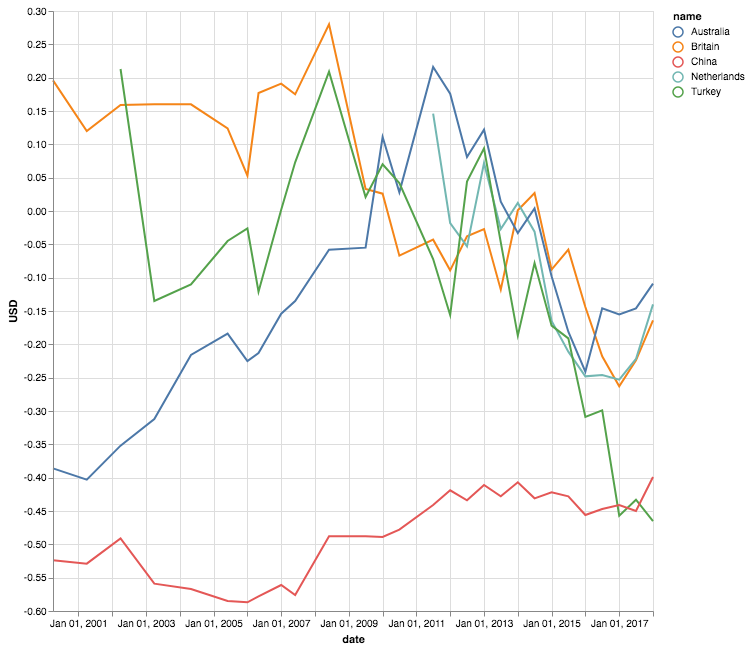

In [16]:
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['date'], empty='none')

countries_of_interest = ['Britain', 'Netherlands', 'Australia', 'Turkey', 'China']


line = alt.Chart(
    adjusted_price[countries_of_interest].loc['USD'].round(3).reset_index()
).mark_line().encode(
    x='date:T',
    color='name:N',
    y='USD:Q'
)

selectors = alt.Chart().mark_point().encode(
    x='date:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'USD:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart().mark_rule(color='gray').encode(
    x='date:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text,
    data=adjusted_price[countries_of_interest].loc['USD'].round(3).reset_index(),
    width=600, 
    height=600
)

### Showing the entire chart

View the complete adjusted Big Mac Index table, using a context manager with pandas.

In [17]:
from contextlib import contextmanager
from IPython.core.interactiveshell import InteractiveShell

In [18]:
InteractiveShell.ast_node_interactivity = 'last'

In [19]:
@contextmanager
def display_full_dataframe():
    old_max_rows = pd.options.display.max_rows
    old_max_columns = pd.options.display.max_columns
    pd.options.display.max_rows = None
    pd.options.display.max_columns = None

    yield
    
    pd.options.display.max_rows = old_max_rows
    pd.options.display.max_columns = old_max_columns

In [20]:
with display_full_dataframe():
    adjusted_price.loc['EUR'].unstack()

date            2000-04-01  2001-04-01  2002-04-01  2003-04-01  2004-05-01  \
name                                                                         
Argentina         0.050067    0.105412   -0.663880   -0.522438   -0.550497   
Australia        -0.352459   -0.330053   -0.321254   -0.374923   -0.308781   
Austria                NaN         NaN         NaN         NaN         NaN   
Belgium                NaN         NaN         NaN         NaN         NaN   
Brazil           -0.307777   -0.273154   -0.352581   -0.502823   -0.483542   
Britain           0.260921    0.258268    0.214283    0.054747    0.023479   
Canada           -0.185662   -0.056148   -0.107428   -0.259679   -0.291829   
Chile             0.029638   -0.072999   -0.100533   -0.344077   -0.335740   
China            -0.497794   -0.471325   -0.466349   -0.598909   -0.617993   
Colombia               NaN         NaN         NaN         NaN   -0.286279   
Costa Rica             NaN         NaN         NaN         NaN   -0.207303   
Czech Republic   -0.415937   -0.365097   -0.303415   -0.343361   -0.352477   
Denmark           0.292993    0.293567    0.242882    0.373002    0.356878   
Egypt                  NaN         NaN         NaN   -0.546679   -0.508665   
Estonia                NaN         NaN         NaN         NaN         NaN   
Euro area         0.000000    0.000000    0.000000    0.000000    0.000000   
Finland                NaN         NaN         NaN         NaN         NaN   
France                 NaN         NaN         NaN         NaN         NaN   
Germany                NaN         NaN         NaN         NaN         NaN   
Greece                 NaN         NaN         NaN         NaN         NaN   
Hong Kong        -0.450029   -0.393441   -0.410849   -0.505415   -0.531497   
Hungary          -0.489645   -0.417743   -0.289862   -0.266186   -0.236056   
India                  NaN         NaN         NaN         NaN         NaN   
Indonesia        -0.233431   -0.401214   -0.285986   -0.382051   -0.463093   
Ireland                NaN         NaN         NaN         NaN         NaN   
Israel            0.503800         NaN    0.054252         NaN         NaN   
Italy                  NaN         NaN         NaN         NaN         NaN   
Japan             0.164980    0.048359   -0.151881   -0.267584   -0.294835   
Lithuania              NaN         NaN         NaN         NaN         NaN   
Malaysia         -0.500389   -0.474057   -0.441857   -0.555077   -0.596619   
Mexico           -0.067103    0.042348   -0.006896   -0.267281   -0.370753   
Netherlands            NaN         NaN         NaN         NaN         NaN   
New Zealand      -0.289507   -0.355549   -0.323678   -0.255585   -0.193297   
Norway                 NaN         NaN    0.720652         NaN    0.576388   
Pakistan               NaN         NaN         NaN         NaN   -0.420793   
Peru                   NaN         NaN    0.042854   -0.234070   -0.216566   
Philippines            NaN   -0.481357   -0.463658   -0.584671   -0.624590   
Poland           -0.462756   -0.352662   -0.385433   -0.456713   -0.504894   
Portugal               NaN         NaN         NaN         NaN         NaN   
Russia           -0.417857   -0.464506   -0.473972   -0.557756   -0.559527   
Saudi Arabia           NaN         NaN         NaN         NaN   -0.805363   
Singapore        -0.209361   -0.193843   -0.236971   -0.378084   -0.413070   
South Africa     -0.437464   -0.472448   -0.625507   -0.381000   -0.433740   
South Korea       0.137257    0.001128    0.000421   -0.092614   -0.173121   
Spain                  NaN         NaN         NaN         NaN         NaN   
Sri Lanka              NaN         NaN         NaN         NaN   -0.569908   
Sweden            0.140344    0.032291    0.052056    0.206683    0.198960   
Switzerland       0.457740    0.610196    0.597097    0.542617    0.485317   
Taiwan           -0.039154   -0.059224   -0.153518   -0.325228   -0.317059   
Thailand         -0.39

### Showing a chart of the Netherlands over time

Examine the price of the Euro in the Netherlands (and other selected countries) compared to the average price for the Euro over time since the Euro was interoduced.

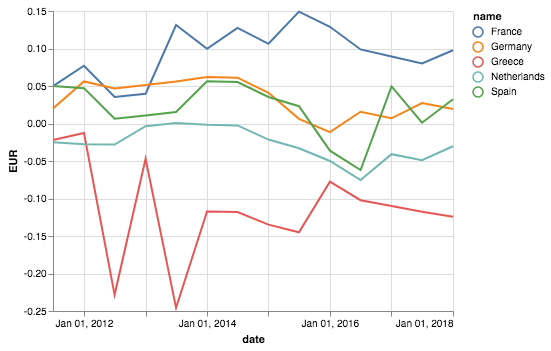

In [21]:
countries_of_interest = ['Netherlands', 'Germany', 'Spain', 'France', 'Greece']

alt.Chart(
    adjusted_price.loc['EUR', countries_of_interest].reset_index()
).mark_line().encode(
    x='date:T',
    color='name:N',
    y='EUR:Q'
)

### Build a `traitlets` class that stores a base currency and allows for price comparison

In [22]:
from datetime import date
import numpy as np
import traitlets

In [23]:
class BaseCurrency(traitlets.HasTraits):
    
    code = traitlets.Unicode()
    date = traitlets.Unicode()

    @traitlets.default('date')
    def _default_date(self):
        d = str(date.today().year)
        #self._update_adjusted_price(d)
        return d
            
    def _update_adjusted_price(self, date):
        """
        Update the adjusted price based on the date and the base currency
        """
        filtered_currencies = big_mac_countries.loc[[self.code]].pivot_table(
            'dollar_price', 'currency_code', 'date').loc[self.code]
        adjusted_prices = big_mac_countries.reset_index().set_index(
            ['iso_a3', 'date']
        )['dollar_price'] / filtered_currencies - 1
        adjusted_prices = adjusted_prices.unstack(0).loc[date]
        if not isinstance(adjusted_prices, type(pd.Series())):
            # if the date is not exact there will be a dataframe at this point, so get the last date.
            adjusted_prices = adjusted_prices.iloc[-1]
        for idx, value in adjusted_prices.items():
            if not np.isnan(value):
                setattr(self, idx, value)
            elif hasattr(self, idx):
                delattr(self, idx)
                
    @traitlets.validate('code')
    def _valid_currency_code(self, proposal):
        if proposal['value'] in big_mac_countries.index:
            return proposal['value']
        raise traitlets.TraitError('code must exist in the Big Mac data table')
        
    @traitlets.validate('date')
    def _valid_year(self, proposal):
        try:
            if not big_mac_countries.loc[self.code].loc[proposal['value']].empty:
                self._update_adjusted_price(proposal['value'])
                return proposal['value']
            raise traitlets.TraitError('Year must have associated currency data')
        except KeyError:
            raise traitlets.TraitError('Year must have associated currency data')
            
    @traitlets.observe('date')
    def _observe_date(self, change):
        self._update_adjusted_price(change['new'])
        
    def __repr__(self):
        return f'BaseCurrency ({self.code} {self.date})'

In [24]:
aud = BaseCurrency(code='AUD')
aud

BaseCurrency (AUD 2018)

You can use `pycountry` to get the three letter code for a given country easily (you will need to `pip install pycountry`):

In [25]:
import pycountry

In [26]:
getattr(aud, pycountry.countries.get(name='Netherlands').alpha_3)

-0.034883721395225775

In [27]:
aud.date = '2017-01-01'

In [28]:
getattr(aud, pycountry.countries.get(name='Netherlands').alpha_3)

-0.11603055289346531